In [307]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchtext
from tqdm import tqdm
# import tqdm
import os
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pandas as pd

In [4]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Load dataset

In [5]:
root = os.getcwd()
dataset_path = os.path.join(root, 'dataset', 'aclImdb')
assert os.path.exists(dataset_path), f'dataset path does not exist {dataset_path}'

train_dataset_path = os.path.join(root, 'dataset', 'aclImdb', 'train')
assert os.path.exists(train_dataset_path), f'train path does not exist {train_dataset_path}'
test_dataset_path = os.path.join(root, 'dataset', 'aclImdb', 'test')
assert os.path.exists(test_dataset_path), f'test path does not exist {test_dataset_path}'

In [61]:
def load_aclImbd_dataset(dataset_root):
    train_root = os.path.join(dataset_root, 'train')
    print('train path = ', train_root)
    test_root = os.path.join(dataset_root, 'test')
    print('test path = ', test_root)
    X_train = []
    y_train = []

    #build train dataset
    print('building train dataset')
    for label in ['neg', 'pos']:
        path = os.path.join(train_root, label)

        for file in tqdm(os.listdir(path)):
            if file.endswith('.txt'):
                with open(os.path.join(path, file), 'r') as reader:
                    text = reader.read()
                    X_train.append(text)
                    y_train.append(label)
    
    X_test = []
    y_test = []

    print('building test dataset')
    for label in ['neg', 'pos']:
        path = os.path.join(test_root, label)

        for file in tqdm(os.listdir(path)):
            if file.endswith('.txt'):
                with open(os.path.join(path, file), 'r') as reader:
                    text = reader.read()
                    X_test.append(text)
                    y_test.append(label)

    return X_train, y_train, X_test, y_test
    
feature_train, label_train, feature_test, label_test = load_aclImbd_dataset(dataset_path)

train path =  e:\ML\NLP\UB DL\assignment1\part4\v3\dataset\aclImdb\train
test path =  e:\ML\NLP\UB DL\assignment1\part4\v3\dataset\aclImdb\test
building train dataset


100%|██████████| 12500/12500 [00:01<00:00, 10397.68it/s]


building test dataset


100%|██████████| 12500/12500 [00:01<00:00, 10822.26it/s]


In [10]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
for label, text in zip(label_train[:10], feature_train[:10]):
    print(f'{label}, {text}')

print("Test")
for label, text in zip(label_test[:10], feature_test[:10]):
    print(f'{label}, {text}')
    

# EDA and plotting

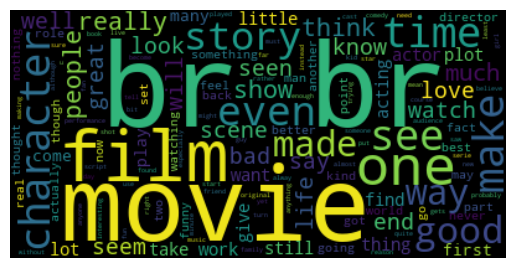

In [289]:
# plot 1, word cloud
wc = WordCloud()
img = wc.generate(text = ' '.join(feature_train))
plt.imshow(img, interpolation='bilinear')
plt.axis('off')
plt.show()

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


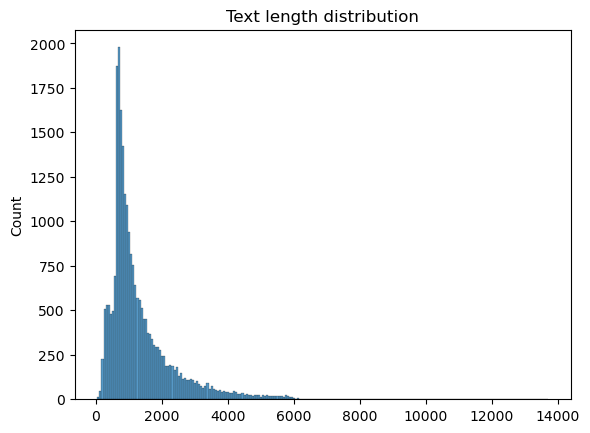

In [291]:
#plot 2, hist of length
lengths = [len(text) for text in feature_train]
sns.histplot(lengths)
plt.title("Text length distribution")
plt.show()

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


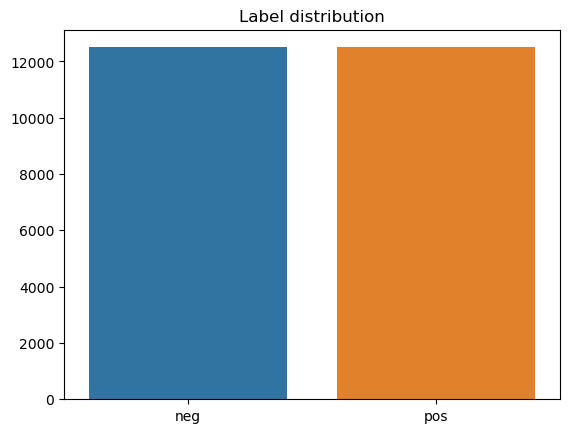

In [317]:
# plot 3, count plots of label 
label_count = Counter(label_train)
keys = list(label_count.keys())
values = list(label_count.values())

sns.barplot(x = keys, y = values)  # You can also use x='category' and y='count' for clarity
plt.title('Label distribution')
plt.show()

# Build array

In [205]:
def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    # if debug:
    #     # print('vocab len = ', len(vocab))
    #     # print('vocab len = ', len(set(y)))
    #     for label, tokens, length in zip(y[:2], X_tokens[:2], X_lengths[:2]):
    #         print(f'label={label}\nlength={length}\ntokens={tokens}')

    # return (X_tokens, y, X_lengths)
    return X_tokens, X_lengths

def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, feature_test, label_test, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)
    test_tokens, test_lengths = build_array(feature_test)

    # (train_tokens, train_y, train_lengths) = build_array(feature_train, label_train, **kwargs)
    # (test_tokens, test_y, test_lengths) = build_array(feature_test, label_test, **kwargs)

    #build vocab
    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens + test_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label == 'neg' else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths
    
    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)
    test_ids, test_y, test_lengths = convert_to_ids_labels_lengths(test_tokens, label_test, test_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), (test_tokens, test_ids, test_y, test_lengths), vocab, pad_id


In [206]:
(train_tokens, train_ids, train_y, train_lengths), \
    (test_tokens, test_ids, test_y, test_lengths),\
        vocab, pad_id = build_train_test_data(feature_train, label_train, feature_test, label_test, debug = True)

100%|██████████| 25000/25000 [00:01<00:00, 19490.92it/s]


In [209]:
print(len(vocab))
print('pad id = ', pad_id)

35292
pad id =  0


In [208]:
for label, token, id, length in zip(train_y[:2], train_tokens[:2], train_ids[:2], train_lengths[:2]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

label=0
tokens=['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a', 'pig', '.', 'starts', 'out', 'with', 'a', 'opening', 'scene', 'that', 'is', 'a', 'terrific', 'example', 'of', 'absurd', 'comedy', '.', 'a', 'formal', 'orchestra', 'audience', 'is', 'turned', 'into', 'an', 'insane', ',', 'violent', 'mob', 'by', 'the', 'crazy', 'chantings', 'of', 'it', "'", 's', 'singers', '.', 'unfortunately', 'it', 'stays', 'absurd', 'the', 'whole', 'time', 'with', 'no', 'general', 'narrative', 'eventually', 'making', 'it', 'just', 'too', 'off', 'putting', '.', 'even', 'those', 'from', 'the', 'era', 'should', 'be', 'turned', 'off', '.', 'the', 'cryptic', 'dialogue', 'would', 'make', 'shakespeare', 'seem', 'easy', 'to', 'a', 'third', 'grader', '.', 'on', 'a', 'technical', 'level', 'it', "'", 's', 'better', 'than', 'you', 'might', 'think', 'with', 'some', 'good', 'cinematography', 'by', 'future', 'great', 'vilmos', 'zsigmond', '.', 'future', 'stars', 'sally', 'kirkland', 'and', 

In [224]:
for label, token, id, length in zip(test_y[:2], test_tokens[:2], test_ids[:2], test_lengths[:2]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

label=0
tokens=['once', 'again', 'mr', '.', 'costner', 'has', 'dragged', 'out', 'a', 'movie', 'for', 'far', 'longer', 'than', 'necessary', '.', 'aside', 'from', 'the', 'terrific', 'sea', 'rescue', 'sequences', ',', 'of', 'which', 'there', 'are', 'very', 'few', 'i', 'just', 'did', 'not', 'care', 'about', 'any', 'of', 'the', 'characters', '.', 'most', 'of', 'us', 'have', 'ghosts', 'in', 'the', 'closet', ',', 'and', 'costner', "'", 's', 'character', 'are', 'realized', 'early', 'on', ',', 'and', 'then', 'forgotten', 'until', 'much', 'later', ',', 'by', 'which', 'time', 'i', 'did', 'not', 'care', '.', 'the', 'character', 'we', 'should', 'really', 'care', 'about', 'is', 'a', 'very', 'cocky', ',', 'overconfident', 'ashton', 'kutcher', '.', 'the', 'problem', 'is', 'he', 'comes', 'off', 'as', 'kid', 'who', 'thinks', 'he', "'", 's', 'better', 'than', 'anyone', 'else', 'around', 'him', 'and', 'shows', 'no', 'signs', 'of', 'a', 'cluttered', 'closet', '.', 'his', 'only', 'obstacle', 'appears', 'to'

## Convert data to tensor

In [215]:
train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

test_ids = pad_sequence(test_ids, batch_first=True, padding_value=pad_id)

In [216]:
print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

ids shape =  torch.Size([25000, 256])
y shape =  torch.Size([25000])
lengths shape =  torch.Size([25000])


In [217]:
#Test set
print('ids shape = ', test_ids.shape )
print('y shape = ', test_y.shape )
print('lengths shape = ', test_lengths.shape)

ids shape =  torch.Size([25000, 256])
y shape =  torch.Size([25000])
lengths shape =  torch.Size([25000])


# Build dataset

In [232]:
class MovieReviewDataset(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = MovieReviewDataset(train_ids, train_y, train_lengths)


train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])
test_dataset = MovieReviewDataset(test_ids, test_y, test_lengths)


print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('val dataset len = ', len(val_dataset))
print('test datasel len = ', len(test_dataset))

num class =  2
train dataset len =  20000
val dataset len =  5000
test datasel len =  25000


In [228]:
BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('train dataloader len = ' ,len(train_dataloader))
print('val dataloader len = ' ,len(val_dataloader))
print('test dataloader len = ' ,len(test_dataloader))

sampleX, sampleY, sampleLength = next(iter(train_dataloader))

print("Sample X shape = ", sampleX.shape)
print("Sample y shape = ", sampleY.shape)
print("Sample length shape = ", sampleLength.shape)

train dataloader len =  79
val dataloader len =  20
test dataloader len =  98
Sample X shape =  torch.Size([256, 256])
Sample y shape =  torch.Size([256])
Sample length shape =  torch.Size([256])


# Build model

In [251]:
class LSTM(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction


In [278]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training loop

In [244]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [270]:
def tune(model, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.apply(initialize_weights)
    print(f"The model has {count_parameters(model):,} trainable parameters")

    vectors = torchtext.vocab.GloVe()
    pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
    print(vocab.get_itos())
    print(pretrained_embedding.shape)
    print(pretrained_embedding)
    model.embedding.weight.data = pretrained_embedding


    model = model.to(device)
    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(10):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)
        if test_loss < best_valid_loss:
            best_valid_loss = test_loss 
            torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
    epochs = list(range(len(history['test_accs'])))
    sns.lineplot(y = history["train_accs"], label ='train accuracy', x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy', x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Baseline

output dim =  2
The model has 14,198,402 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.23it/s]


epoch: 0
train_loss: 0.567, train_acc: 0.692
val_loss: 0.459, valid_acc: 0.781
test_loss: 0.469, test_acc: 0.779


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.35it/s]


epoch: 1
train_loss: 0.521, train_acc: 0.746
val_loss: 0.551, valid_acc: 0.716
test_loss: 0.554, test_acc: 0.711


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.56it/s]


epoch: 2
train_loss: 0.611, train_acc: 0.667
val_loss: 0.578, valid_acc: 0.692
test_loss: 0.573, test_acc: 0.697


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.79it/s]


epoch: 3
train_loss: 0.577, train_acc: 0.696
val_loss: 0.541, valid_acc: 0.735
test_loss: 0.540, test_acc: 0.731


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.87it/s]


epoch: 4
train_loss: 0.454, train_acc: 0.790
val_loss: 0.394, valid_acc: 0.830
test_loss: 0.401, test_acc: 0.825


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.30it/s]


epoch: 5
train_loss: 0.375, train_acc: 0.833
val_loss: 0.445, valid_acc: 0.822
test_loss: 0.445, test_acc: 0.819


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.78it/s]


epoch: 6
train_loss: 0.359, train_acc: 0.850
val_loss: 0.406, valid_acc: 0.849
test_loss: 0.420, test_acc: 0.844


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.30it/s]


epoch: 7
train_loss: 0.319, train_acc: 0.868
val_loss: 0.354, valid_acc: 0.858
test_loss: 0.377, test_acc: 0.849


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.17it/s]


epoch: 8
train_loss: 0.259, train_acc: 0.899
val_loss: 0.343, valid_acc: 0.867
test_loss: 0.370, test_acc: 0.855


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.51it/s]
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_

epoch: 9
train_loss: 0.240, train_acc: 0.905
val_loss: 0.378, valid_acc: 0.857
test_loss: 0.425, test_acc: 0.844


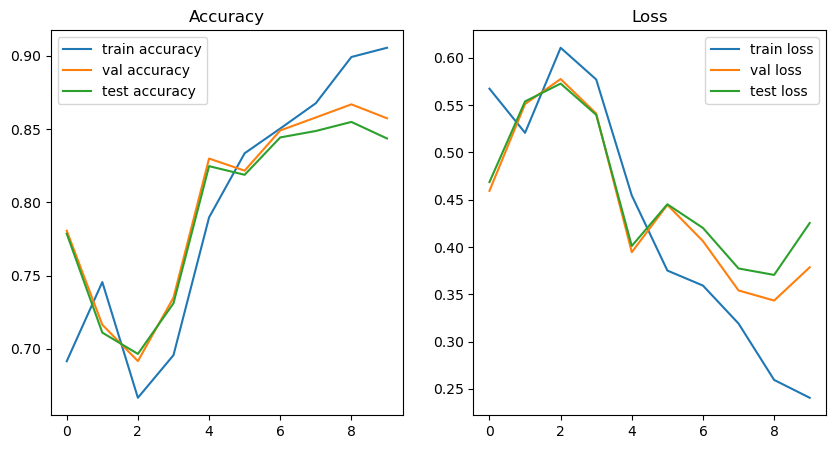

In [271]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# Hyperparms tuning #1, hidden_dim = 500

output dim =  2
The model has 19,805,602 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


epoch: 0
train_loss: 0.613, train_acc: 0.672
val_loss: 0.469, valid_acc: 0.799
test_loss: 0.478, test_acc: 0.789


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


epoch: 1
train_loss: 0.588, train_acc: 0.694
val_loss: 0.517, valid_acc: 0.746
test_loss: 0.528, test_acc: 0.736


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


epoch: 2
train_loss: 0.601, train_acc: 0.667
val_loss: 0.614, valid_acc: 0.656
test_loss: 0.610, test_acc: 0.662


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]


epoch: 3
train_loss: 0.468, train_acc: 0.777
val_loss: 0.396, valid_acc: 0.832
test_loss: 0.408, test_acc: 0.826


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.17it/s]


epoch: 4
train_loss: 0.458, train_acc: 0.790
val_loss: 0.619, valid_acc: 0.683
test_loss: 0.622, test_acc: 0.674


evaluating...: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s]


epoch: 5
train_loss: 0.559, train_acc: 0.723
val_loss: 0.559, valid_acc: 0.719
test_loss: 0.562, test_acc: 0.718


evaluating...: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


epoch: 6
train_loss: 0.415, train_acc: 0.813
val_loss: 0.354, valid_acc: 0.847
test_loss: 0.370, test_acc: 0.843


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]


epoch: 7
train_loss: 0.296, train_acc: 0.878
val_loss: 0.307, valid_acc: 0.866
test_loss: 0.330, test_acc: 0.859


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


epoch: 8
train_loss: 0.263, train_acc: 0.896
val_loss: 0.340, valid_acc: 0.865
test_loss: 0.351, test_acc: 0.856


evaluating...: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 9
train_loss: 0.234, train_acc: 0.910
val_loss: 0.286, valid_acc: 0.884
test_loss: 0.311, test_acc: 0.870


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

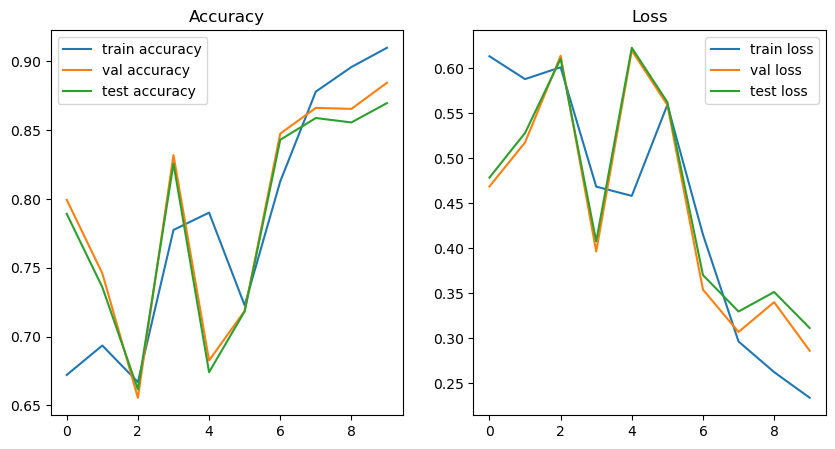

In [272]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 500
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# Hyperparms tuning #2, bidirectional = False

output dim =  2
The model has 12,033,002 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:02<00:00, 35.61it/s]


epoch: 0
train_loss: 0.617, train_acc: 0.651
val_loss: 0.487, valid_acc: 0.788
test_loss: 0.485, test_acc: 0.790


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 35.60it/s]


epoch: 1
train_loss: 0.491, train_acc: 0.771
val_loss: 0.718, valid_acc: 0.748
test_loss: 0.711, test_acc: 0.750


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 34.84it/s]


epoch: 2
train_loss: 0.428, train_acc: 0.815
val_loss: 0.372, valid_acc: 0.834
test_loss: 0.384, test_acc: 0.828


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 33.40it/s]


epoch: 3
train_loss: 0.403, train_acc: 0.825
val_loss: 0.390, valid_acc: 0.844
test_loss: 0.415, test_acc: 0.835


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 35.31it/s]


epoch: 4
train_loss: 0.474, train_acc: 0.771
val_loss: 0.411, valid_acc: 0.818
test_loss: 0.433, test_acc: 0.811


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 34.59it/s]


epoch: 5
train_loss: 0.423, train_acc: 0.827
val_loss: 0.903, valid_acc: 0.702
test_loss: 0.889, test_acc: 0.707


evaluating...: 100%|██████████| 98/98 [00:03<00:00, 29.82it/s]


epoch: 6
train_loss: 0.393, train_acc: 0.837
val_loss: 0.378, valid_acc: 0.849
test_loss: 0.397, test_acc: 0.844


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 33.05it/s]


epoch: 7
train_loss: 0.289, train_acc: 0.887
val_loss: 0.352, valid_acc: 0.870
test_loss: 0.388, test_acc: 0.857


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 34.57it/s]


epoch: 8
train_loss: 0.263, train_acc: 0.895
val_loss: 0.315, valid_acc: 0.873
test_loss: 0.344, test_acc: 0.858


evaluating...: 100%|██████████| 98/98 [00:02<00:00, 35.16it/s]
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_

epoch: 9
train_loss: 0.489, train_acc: 0.744
val_loss: 0.558, valid_acc: 0.730
test_loss: 0.564, test_acc: 0.715


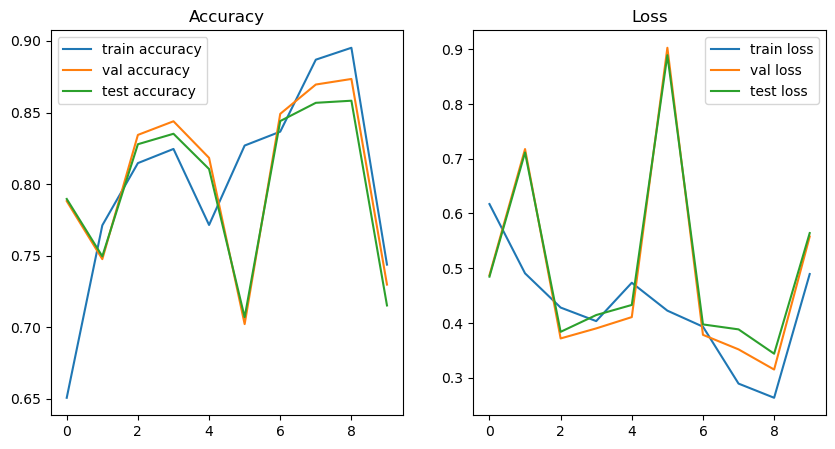

In [273]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = False
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# Hyperparms tuning #3, num layers = 5

output dim =  2
The model has 20,692,802 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]


epoch: 0
train_loss: 0.585, train_acc: 0.678
val_loss: 0.472, valid_acc: 0.786
test_loss: 0.480, test_acc: 0.782


evaluating...: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]


epoch: 1
train_loss: 0.556, train_acc: 0.712
val_loss: 0.629, valid_acc: 0.676
test_loss: 0.626, test_acc: 0.679


evaluating...: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]


epoch: 2
train_loss: 0.517, train_acc: 0.747
val_loss: 0.361, valid_acc: 0.840
test_loss: 0.370, test_acc: 0.836


evaluating...: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]


epoch: 3
train_loss: 0.356, train_acc: 0.846
val_loss: 0.381, valid_acc: 0.836
test_loss: 0.388, test_acc: 0.833


evaluating...: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]


epoch: 4
train_loss: 0.308, train_acc: 0.871
val_loss: 0.307, valid_acc: 0.869
test_loss: 0.325, test_acc: 0.863


evaluating...: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]


epoch: 5
train_loss: 0.284, train_acc: 0.885
val_loss: 0.300, valid_acc: 0.882
test_loss: 0.318, test_acc: 0.872


evaluating...: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


epoch: 6
train_loss: 0.232, train_acc: 0.912
val_loss: 0.333, valid_acc: 0.890
test_loss: 0.368, test_acc: 0.877


evaluating...: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]


epoch: 7
train_loss: 0.217, train_acc: 0.917
val_loss: 0.286, valid_acc: 0.893
test_loss: 0.313, test_acc: 0.880


evaluating...: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]


epoch: 8
train_loss: 0.191, train_acc: 0.929
val_loss: 0.287, valid_acc: 0.898
test_loss: 0.331, test_acc: 0.878


evaluating...: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]


epoch: 9
train_loss: 0.166, train_acc: 0.940
val_loss: 0.273, valid_acc: 0.899
test_loss: 0.313, test_acc: 0.878


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

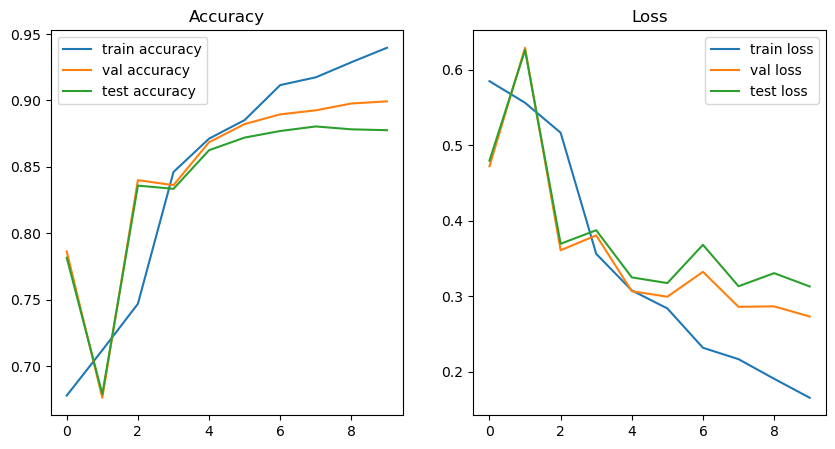

In [274]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 5
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# GRU Classifier

In [281]:
class GRUClassifier(nn.Module):
    def __init__(
        self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
        bidirectional,dropout_rate,pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.gru = nn.GRU(embedding_dim,hidden_dim,n_layers,bidirectional=bidirectional,dropout=dropout_rate,batch_first=True,)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        output, hidden = self.gru(embedded)
        if self.gru.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction


# GRU Baseline

output dim =  2
The model has 13,296,002 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:05<00:00, 16.41it/s]


epoch: 0
train_loss: 0.622, train_acc: 0.645
val_loss: 0.475, valid_acc: 0.782
test_loss: 0.481, test_acc: 0.775


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 15.80it/s]


epoch: 1
train_loss: 0.444, train_acc: 0.797
val_loss: 0.367, valid_acc: 0.842
test_loss: 0.386, test_acc: 0.832


evaluating...: 100%|██████████| 98/98 [00:05<00:00, 16.42it/s]


epoch: 2
train_loss: 0.351, train_acc: 0.851
val_loss: 0.404, valid_acc: 0.855
test_loss: 0.436, test_acc: 0.844


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 14.69it/s]


epoch: 3
train_loss: 0.295, train_acc: 0.878
val_loss: 0.289, valid_acc: 0.882
test_loss: 0.314, test_acc: 0.870


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 16.30it/s]


epoch: 4
train_loss: 0.256, train_acc: 0.900
val_loss: 0.297, valid_acc: 0.885
test_loss: 0.331, test_acc: 0.872


evaluating...: 100%|██████████| 98/98 [00:05<00:00, 16.93it/s]


epoch: 5
train_loss: 0.208, train_acc: 0.919
val_loss: 0.335, valid_acc: 0.880
test_loss: 0.389, test_acc: 0.865


evaluating...: 100%|██████████| 98/98 [00:05<00:00, 16.81it/s]


epoch: 6
train_loss: 0.193, train_acc: 0.926
val_loss: 0.285, valid_acc: 0.898
test_loss: 0.336, test_acc: 0.875


evaluating...: 100%|██████████| 98/98 [00:06<00:00, 16.30it/s]


epoch: 7
train_loss: 0.154, train_acc: 0.941
val_loss: 0.328, valid_acc: 0.894
test_loss: 0.386, test_acc: 0.872


evaluating...: 100%|██████████| 98/98 [00:05<00:00, 16.42it/s]


epoch: 8
train_loss: 0.131, train_acc: 0.953
val_loss: 0.494, valid_acc: 0.863
test_loss: 0.646, test_acc: 0.826


evaluating...: 100%|██████████| 98/98 [00:05<00:00, 16.76it/s]
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_

epoch: 9
train_loss: 0.113, train_acc: 0.959
val_loss: 0.329, valid_acc: 0.896
test_loss: 0.417, test_acc: 0.869


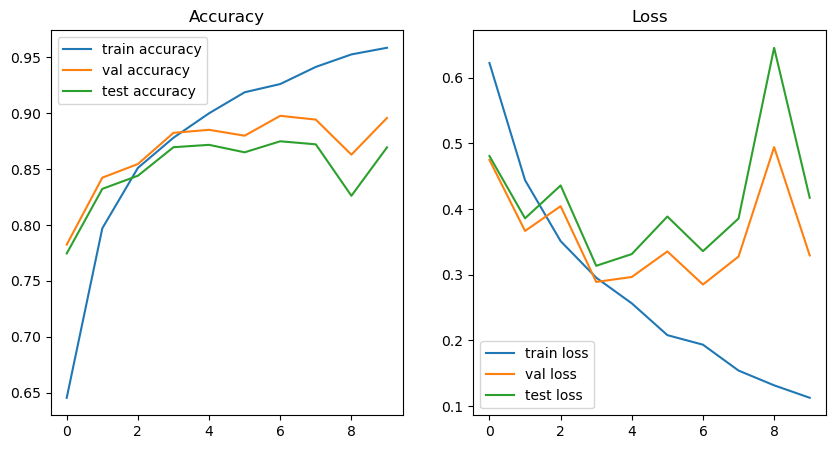

In [282]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = GRUClassifier(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# GRU Hyperparams tunning #1, hidden_dim= 100

output dim =  2
The model has 11,010,402 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

evaluating...: 100%|██████████| 98/98 [00:04<00:00, 22.24it/s]


epoch: 0
train_loss: 0.658, train_acc: 0.601
val_loss: 0.555, valid_acc: 0.717
test_loss: 0.555, test_acc: 0.715


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.31it/s]


epoch: 1
train_loss: 0.507, train_acc: 0.756
val_loss: 0.471, valid_acc: 0.807
test_loss: 0.490, test_acc: 0.800


evaluating...: 100%|██████████| 98/98 [00:05<00:00, 19.23it/s]


epoch: 2
train_loss: 0.375, train_acc: 0.836
val_loss: 0.424, valid_acc: 0.823
test_loss: 0.445, test_acc: 0.815


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.16it/s]


epoch: 3
train_loss: 0.318, train_acc: 0.868
val_loss: 0.317, valid_acc: 0.874
test_loss: 0.339, test_acc: 0.863


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.79it/s]


epoch: 4
train_loss: 0.270, train_acc: 0.891
val_loss: 0.307, valid_acc: 0.887
test_loss: 0.332, test_acc: 0.874


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.29it/s]


epoch: 5
train_loss: 0.241, train_acc: 0.903
val_loss: 0.333, valid_acc: 0.875
test_loss: 0.361, test_acc: 0.862


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 22.38it/s]


epoch: 6
train_loss: 0.203, train_acc: 0.923
val_loss: 0.271, valid_acc: 0.898
test_loss: 0.304, test_acc: 0.880


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.75it/s]


epoch: 7
train_loss: 0.173, train_acc: 0.935
val_loss: 0.301, valid_acc: 0.901
test_loss: 0.355, test_acc: 0.877


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.03it/s]


epoch: 8
train_loss: 0.156, train_acc: 0.941
val_loss: 0.304, valid_acc: 0.900
test_loss: 0.365, test_acc: 0.876


evaluating...: 100%|██████████| 98/98 [00:04<00:00, 21.98it/s]
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_

epoch: 9
train_loss: 0.129, train_acc: 0.951
val_loss: 0.314, valid_acc: 0.901
test_loss: 0.388, test_acc: 0.873


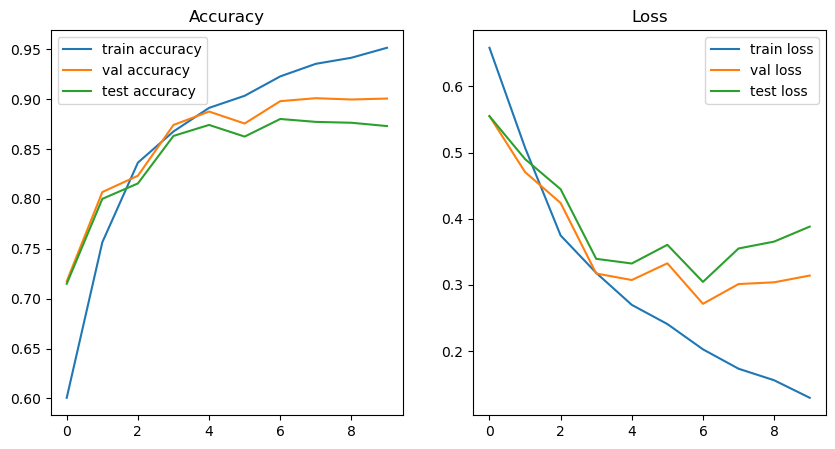

In [283]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 100
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = GRUClassifier(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

# GRU Hyperparams tunning #2 num layers = 5

In [285]:
torch.cuda.empty_cache()

In [286]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 5
bidirectional = True
dropout_rate = 0.5

model = GRUClassifier(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_id,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tune(model, optimizer, criterion)

torch.save(model,'gru.best.torch')

output dim =  2
The model has 18,166,802 trainable parameters
['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'", 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'as', 'with', 'for', 'but', 'film', ')', '(', 'you', 'on', 't', 'not', 'are', 'have', 'his', 'one', 'he', 'be', '!', 'at', 'all', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'about', 'just', 'or', 'has', 'if', 'out', 'what', 'her', 'some', '?', 'good', 'very', 'can', 'when', 'my', 'more', 'time', 'story', 'she', 'no', 'would', 'even', 'really', 'up', 'see', 'only', 'had', 'me', 'which', 'were', 'their', 'we', 'bad', 'well', 'great', 'much', 'people', 'first', '-', 'than', 'been', 'get', 'other', 'how', 'don', 'do', 'because', 'most', 'will', 'into', 'movies', 'also', 'made', 'its', 'could', 'then', 'him', 'them', 'make', 'way', 'after', 'characters', 'watch', 'seen', 'too', 'think', 'any', 'plot', 'acting', 'films', 'many', 'love', 'show', 'character', 'two', 'ever', 'best', 'did', 'being

training...:   0%|          | 0/79 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.82 GiB (GPU 0; 12.00 GiB total capacity; 2.97 GiB already allocated; 1.87 GiB free; 8.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# References

https://www.bing.com/ck/a?!&&p=6526a307675ad68bJmltdHM9MTcwOTg1NjAwMCZpZ3VpZD0yNTE0ZTMxYy02MGM5LTZkY2EtMWMxNi1mMGQxNjE2MTZjOTcmaW5zaWQ9NTIwOQ&ptn=3&ver=2&hsh=3&fclid=2514e31c-60c9-6dca-1c16-f0d161616c97&psq=torch.LSTM&u=a1aHR0cHM6Ly9weXRvcmNoLm9yZy9kb2NzL3N0YWJsZS9nZW5lcmF0ZWQvdG9yY2gubm4uTFNUTS5odG1s&ntb=1

https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch